In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lab3-resnet50/train_images_resnet50.csv
/kaggle/input/lab3-resnet50/test_images_resnet50.csv
/kaggle/input/lab36-vgg19/train_images_vgg19.csv
/kaggle/input/lab36-vgg19/test_images_vgg19.csv
/kaggle/input/lab3-vgg16/test_images_vgg16.csv
/kaggle/input/lab3-vgg16/train_images_vgg16.csv
/kaggle/input/lab3-efficientnet/test_images_efficient_net.csv
/kaggle/input/lab3-efficientnet/train_images_efficent_net.csv
/kaggle/input/lab3-inceptionv3/test_images_inceptionv3.csv
/kaggle/input/lab3-inceptionv3/train_images_inceptionv3.csv


In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from keras.models import Sequential
from keras.layers import Dense

# Main task

## Raw Hog Embeddings

In [4]:
train_raw_hogs = pd.read_csv('/kaggle/input/lab3-rawhogembeddings/raw_hog_embeddings_train.csv')
test_raw_hogs = pd.read_csv('/kaggle/input/lab3-rawhogembeddings/raw_hog_embeddings_test.csv')

In [5]:
train_raw_hogs.head(2)

,image_name,target,0,1,2,3,4,5,6,7,...,34586,34587,34588,34589,34590,34591,34592,34593,34594,34595
0,/kaggle/input/real-and-fake-face-detection/rea...,0,0.229916,0.054096,0.229916,0.114668,0.125780,0.229424,0.229916,0.229916,...,0.197192,0.058731,0.015924,0.044487,0.017448,0.214358,0.022509,0.188540,0.012744,0.180506
1,/kaggle/input/real-and-fake-face-detection/rea...,0,0.238039,0.180553,0.159582,0.173781,0.238039,0.148919,0.119426,0.041752,...,0.230621,0.203280,0.170389,0.092759,0.085495,0.230621,0.082703,0.043651,0.070549,0.046353


In [6]:
train_raw_hogs.shape

(967, 34598)

### Raw SVC

In [7]:
svc = SVC(random_state=42, probability=True)

In [8]:
hog_features = train_raw_hogs.columns[2:]

In [11]:
## handle missing values
train_raw_hogs[hog_features] = train_raw_hogs[hog_features].fillna(0)
test_raw_hogs[hog_features] = test_raw_hogs[hog_features].fillna(0)

In [58]:
%%time
svc.fit(train_raw_hogs[hog_features], train_raw_hogs['target'])

CPU times: user 2min 42s, sys: 250 ms, total: 2min 43s
Wall time: 2min 45s


SVC(probability=True, random_state=42)

### PCA + SVC

In [18]:
pca = PCA(n_components=500, random_state=42)

In [19]:
%%time
train_raw_hogs_transformed = pca.fit_transform(train_raw_hogs[hog_features])

CPU times: user 11 s, sys: 572 ms, total: 11.5 s
Wall time: 11.7 s


In [20]:
%%time
test_raw_hogs_transformed = pca.transform(test_raw_hogs[hog_features])

CPU times: user 615 ms, sys: 68.1 ms, total: 683 ms
Wall time: 684 ms


In [21]:
svc_hog_transformed = SVC(random_state=42, probability=True)

In [23]:
%%time
svc_hog_transformed.fit(train_raw_hogs_transformed,
                        train_raw_hogs['target'])

CPU times: user 2.31 s, sys: 1.99 ms, total: 2.31 s
Wall time: 2.31 s


SVC(probability=True, random_state=42)

## Dense Net, raw hog features

In [25]:
train_raw_hogs.shape

(967, 34598)

In [30]:
model_raw_hog = Sequential()
model_raw_hog.add(Dense(12, input_dim=len(hog_features), activation='relu'))
model_raw_hog.add(Dense(8, activation='relu'))
model_raw_hog.add(Dense(1, activation='sigmoid'))

In [31]:
model_raw_hog.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                415164    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 415,277
Trainable params: 415,277
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_raw_hog.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

In [34]:
%%time
model_raw_hog.fit(train_raw_hogs[hog_features], train_raw_hogs['target'],
                  epochs=150, batch_size=10)

Epoch 1/150
97/97 [==============================] - 0s 5ms/step - loss: 0.1072 - accuracy: 0.9845 - auc: 0.9989
Epoch 2/150
97/97 [==============================] - 0s 4ms/step - loss: 0.0832 - accuracy: 0.9897 - auc: 0.9994
Epoch 3/150
97/97 [==============================] - 0s 5ms/step - loss: 0.0810 - accuracy: 0.9835 - auc: 0.9984
Epoch 4/150
97/97 [==============================] - 0s 5ms/step - loss: 0.0478 - accuracy: 0.9959 - auc: 1.0000
Epoch 5/150
97/97 [==============================] - 0s 4ms/step - loss: 0.0321 - accuracy: 1.0000 - auc: 1.0000
Epoch 6/150
97/97 [==============================] - 0s 4ms/step - loss: 0.0221 - accuracy: 1.0000 - auc: 1.0000
Epoch 7/150
97/97 [==============================] - 0s 4ms/step - loss: 0.0190 - accuracy: 1.0000 - auc: 1.0000
Epoch 8/150
97/97 [==============================] - 0s 4ms/step - loss: 0.0141 - accuracy: 1.0000 - auc: 1.0000
Epoch 9/150
97/97 [==============================] - 0s 4ms/step - loss: 0.0114 - accuracy: 1.00

97/97 [==============================] - 1s 6ms/step - loss: 6.6551e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 72/150
97/97 [==============================] - 1s 5ms/step - loss: 6.2588e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 73/150
97/97 [==============================] - 0s 4ms/step - loss: 5.8860e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 74/150
97/97 [==============================] - 0s 4ms/step - loss: 5.5399e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 75/150
97/97 [==============================] - 0s 4ms/step - loss: 5.2167e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 76/150
97/97 [==============================] - 0s 4ms/step - loss: 4.9148e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 77/150
97/97 [==============================] - 0s 4ms/step - loss: 4.6258e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 78/150
97/97 [==============================] - 0s 4ms/step - loss: 4.3683e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 79/150
97/97 [==============================] - 0s 5ms/step - l

#### Metrics per iteration for Dense Net

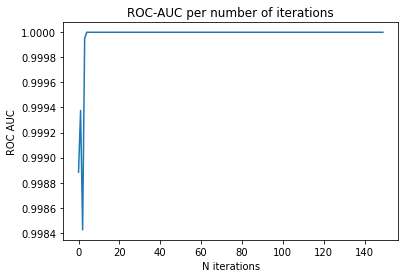

In [40]:
plt.plot(model_raw_hog.history.history['auc']);
plt.title('ROC-AUC per number of iterations');
plt.xlabel('N iterations');
plt.ylabel('ROC AUC');

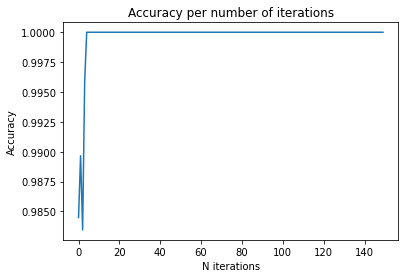

In [41]:
plt.plot(model_raw_hog.history.history['accuracy']);
plt.title('Accuracy per number of iterations');
plt.xlabel('N iterations');
plt.ylabel('Accuracy');

## Dense Net + PCA

In [42]:
train_raw_hogs_transformed.shape

(967, 500)

In [43]:
model_raw_hog_pca = Sequential()
model_raw_hog_pca.add(Dense(12, input_dim=500, activation='relu'))
model_raw_hog_pca.add(Dense(8, activation='relu'))
model_raw_hog_pca.add(Dense(1, activation='sigmoid'))

In [44]:
model_raw_hog_pca.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 12)                6012      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 6,125
Trainable params: 6,125
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_raw_hog_pca.compile(loss='binary_crossentropy', optimizer='adam',
                          metrics=['accuracy', 'AUC'])

In [46]:
%%time
model_raw_hog_pca.fit(train_raw_hogs_transformed, train_raw_hogs['target'],
                  epochs=150, batch_size=10)

Epoch 1/150
97/97 [==============================] - 0s 3ms/step - loss: 0.5455 - accuracy: 0.7239 - auc: 0.6678
Epoch 2/150
97/97 [==============================] - 0s 3ms/step - loss: 0.4110 - accuracy: 0.8014 - auc: 0.8361
Epoch 3/150
97/97 [==============================] - 0s 3ms/step - loss: 0.3543 - accuracy: 0.8170 - auc: 0.9083
Epoch 4/150
97/97 [==============================] - 0s 3ms/step - loss: 0.2916 - accuracy: 0.8728 - auc: 0.9607
Epoch 5/150
97/97 [==============================] - 0s 3ms/step - loss: 0.2185 - accuracy: 0.9307 - auc: 0.9831
Epoch 6/150
97/97 [==============================] - 0s 3ms/step - loss: 0.1460 - accuracy: 0.9710 - auc: 0.9941
Epoch 7/150
97/97 [==============================] - 1s 6ms/step - loss: 0.0889 - accuracy: 0.9835 - auc: 0.9987
Epoch 8/150
97/97 [==============================] - 0s 5ms/step - loss: 0.0552 - accuracy: 0.9907 - auc: 0.9996
Epoch 9/150
97/97 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.99

97/97 [==============================] - 0s 3ms/step - loss: 4.4024e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 141/150
97/97 [==============================] - 0s 3ms/step - loss: 4.1895e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 142/150
97/97 [==============================] - 0s 3ms/step - loss: 3.9635e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 143/150
97/97 [==============================] - 0s 3ms/step - loss: 3.7565e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 144/150
97/97 [==============================] - 0s 3ms/step - loss: 3.5619e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 145/150
97/97 [==============================] - 0s 3ms/step - loss: 3.3925e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 146/150
97/97 [==============================] - 0s 3ms/step - loss: 3.2073e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 147/150
97/97 [==============================] - 0s 3ms/step - loss: 3.0418e-06 - accuracy: 1.0000 - auc: 1.0000
Epoch 148/150
97/97 [==============================] - 0s 3ms/

#### Metrics per iteration for Dense Net + PCA

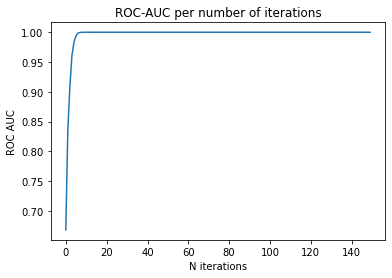

In [47]:
plt.plot(model_raw_hog_pca.history.history['auc']);
plt.title('ROC-AUC per number of iterations');
plt.xlabel('N iterations');
plt.ylabel('ROC AUC');

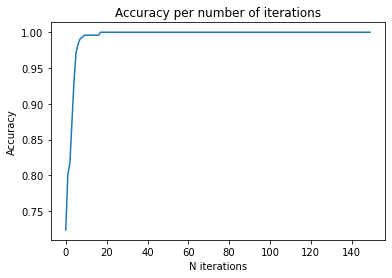

In [48]:
plt.plot(model_raw_hog_pca.history.history['accuracy']);
plt.title('Accuracy per number of iterations');
plt.xlabel('N iterations');
plt.ylabel('Accuracy');

# Viola-Jones + Hog Embeddings

In [49]:
train_viola_jones_hogs = pd.read_csv('/kaggle/input/lab3-viola-jones-hog-embeddings/viola_jones_3_3_hog_embeddings_train.csv')
test_viola_jones_hogs = pd.read_csv('/kaggle/input/lab3-viola-jones-hog-embeddings/viola_jones_3_3_hog_embeddings_test.csv')

In [50]:
train_viola_jones_hogs.head(2)

,image_name,target,0,1,2,3,4,5,6,7,...,24326,24327,24328,24329,24330,24331,24332,24333,24334,24335
0,/kaggle/input/real-and-fake-face-detection/rea...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/kaggle/input/real-and-fake-face-detection/rea...,0,0.323051,0.123716,0.10009,0.136105,0.323051,0.308274,0.030495,0.231455,...,0.005944,0.196936,0.0,0.142117,0.031834,0.286887,0.022326,0.017426,0.013486,0.286887


In [51]:
train_viola_jones_hogs.shape

(967, 24338)

In [52]:
viola_jones_hog_features = train_viola_jones_hogs.columns[2:]

### Raw SVC

In [54]:
svc_viola_jones_hog = SVC(random_state=42, probability=True)

In [55]:
## handle missing values
train_viola_jones_hogs[viola_jones_hog_features] = train_viola_jones_hogs[
    viola_jones_hog_features].fillna(0)
test_viola_jones_hogs[viola_jones_hog_features] = test_viola_jones_hogs[
    viola_jones_hog_features].fillna(0)

In [57]:
%%time
svc_viola_jones_hog.fit(train_viola_jones_hogs[viola_jones_hog_features],
                        train_viola_jones_hogs['target'])

CPU times: user 1min 24s, sys: 162 ms, total: 1min 24s
Wall time: 1min 25s


SVC(probability=True, random_state=42)

### PCA + SVC

In [59]:
pca_viola_hogs = PCA(n_components=500, random_state=42)

In [60]:
%%time
train_viola_jones_hogs_transformed = pca_viola_hogs.fit_transform(
    train_viola_jones_hogs[viola_jones_hog_features])

CPU times: user 8.46 s, sys: 441 ms, total: 8.9 s
Wall time: 8.95 s


In [62]:
%%time
test_viola_jones_hogs_transformed = pca_viola_hogs.transform(
    test_viola_jones_hogs[viola_jones_hog_features])

CPU times: user 434 ms, sys: 51.4 ms, total: 486 ms
Wall time: 485 ms


In [63]:
svc_viola_jones_hog_transformed = SVC(random_state=42, probability=True)

In [64]:
%%time
svc_viola_jones_hog_transformed.fit(train_viola_jones_hogs_transformed,
                                    train_viola_jones_hogs['target'])

CPU times: user 1.68 s, sys: 1.44 ms, total: 1.68 s
Wall time: 1.68 s


SVC(probability=True, random_state=42)

## Dense Net, raw hog features

In [65]:
train_viola_jones_hogs.shape

(967, 24338)

In [66]:
model_viola_jones_hog = Sequential()
model_viola_jones_hog.add(Dense(12, input_dim=len(viola_jones_hog_features), activation='relu'))
model_viola_jones_hog.add(Dense(8, activation='relu'))
model_viola_jones_hog.add(Dense(1, activation='sigmoid'))

In [67]:
model_viola_jones_hog.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12)                292044    
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 292,157
Trainable params: 292,157
Non-trainable params: 0
_________________________________________________________________


In [68]:
model_viola_jones_hog.compile(loss='binary_crossentropy', optimizer='adam',
                              metrics=['accuracy', 'AUC'])

In [70]:
%%time
model_viola_jones_hog.fit(train_viola_jones_hogs[viola_jones_hog_features],
                          train_viola_jones_hogs['target'],
                          epochs=150, batch_size=10)

Epoch 1/150
97/97 [==============================] - 1s 6ms/step - loss: 0.6883 - accuracy: 0.7518 - auc: 0.4776
Epoch 2/150
97/97 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.7818 - auc: 0.4518
Epoch 3/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5970 - accuracy: 0.7818 - auc: 0.4549
Epoch 4/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5687 - accuracy: 0.7818 - auc: 0.4963
Epoch 5/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5494 - accuracy: 0.7818 - auc: 0.5030
Epoch 6/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5230 - accuracy: 0.7818 - auc: 0.5704
Epoch 7/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5072 - accuracy: 0.7818 - auc: 0.6191
Epoch 8/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5017 - accuracy: 0.7818 - auc: 0.6483
Epoch 9/150
97/97 [==============================] - 0s 4ms/step - loss: 0.4948 - accuracy: 0.78

97/97 [==============================] - 0s 4ms/step - loss: 0.5175 - accuracy: 0.7818 - auc: 0.5343
Epoch 144/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5177 - accuracy: 0.7818 - auc: 0.5329
Epoch 145/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5178 - accuracy: 0.7818 - auc: 0.5480
Epoch 146/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5178 - accuracy: 0.7818 - auc: 0.5357
Epoch 147/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5175 - accuracy: 0.7818 - auc: 0.5289
Epoch 148/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5176 - accuracy: 0.7818 - auc: 0.5407
Epoch 149/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5176 - accuracy: 0.7818 - auc: 0.5401
Epoch 150/150
97/97 [==============================] - 0s 4ms/step - loss: 0.5175 - accuracy: 0.7818 - auc: 0.5396
CPU times: user 1min 17s, sys: 8.7 s, total: 1min 26s
Wall time: 1min 2s


#### Metrics per iteration for Dense Net

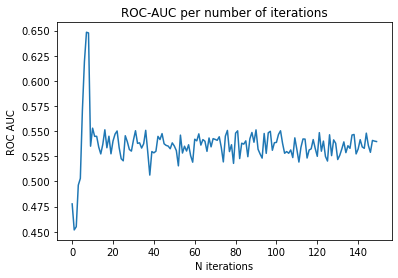

In [71]:
plt.plot(model_viola_jones_hog.history.history['auc']);
plt.title('ROC-AUC per number of iterations');
plt.xlabel('N iterations');
plt.ylabel('ROC AUC');

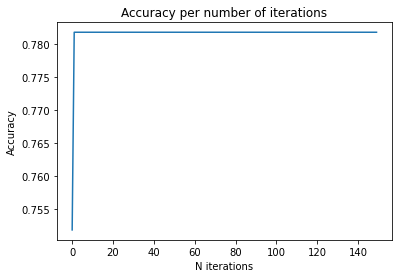

In [72]:
plt.plot(model_viola_jones_hog.history.history['accuracy']);
plt.title('Accuracy per number of iterations');
plt.xlabel('N iterations');
plt.ylabel('Accuracy');

## Dense Net + PCA

In [73]:
train_viola_jones_hogs_transformed.shape

(967, 500)

In [74]:
model_viola_jones_hog_pca = Sequential()
model_viola_jones_hog_pca.add(Dense(12, input_dim=500, activation='relu'))
model_viola_jones_hog_pca.add(Dense(8, activation='relu'))
model_viola_jones_hog_pca.add(Dense(1, activation='sigmoid'))

In [75]:
model_viola_jones_hog_pca.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 12)                6012      
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 6,125
Trainable params: 6,125
Non-trainable params: 0
_________________________________________________________________


In [76]:
model_viola_jones_hog_pca.compile(loss='binary_crossentropy', optimizer='adam',
                                  metrics=['accuracy', 'AUC'])

In [77]:
%%time
model_viola_jones_hog_pca.fit(train_viola_jones_hogs_transformed,
                              train_viola_jones_hogs['target'],
                              epochs=150, batch_size=10)

Epoch 1/150
97/97 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.7549 - auc: 0.4932
Epoch 2/150
97/97 [==============================] - 0s 3ms/step - loss: 0.5717 - accuracy: 0.7890 - auc: 0.5667
Epoch 3/150
97/97 [==============================] - 0s 3ms/step - loss: 0.5100 - accuracy: 0.7932 - auc: 0.6405
Epoch 4/150
97/97 [==============================] - 0s 3ms/step - loss: 0.4774 - accuracy: 0.8025 - auc: 0.6274
Epoch 5/150
97/97 [==============================] - 0s 4ms/step - loss: 0.4582 - accuracy: 0.8232 - auc: 0.6549
Epoch 6/150
97/97 [==============================] - 0s 5ms/step - loss: 0.4448 - accuracy: 0.8304 - auc: 0.6540
Epoch 7/150
97/97 [==============================] - 1s 5ms/step - loss: 0.4354 - accuracy: 0.8356 - auc: 0.6570
Epoch 8/150
97/97 [==============================] - 0s 4ms/step - loss: 0.4287 - accuracy: 0.8345 - auc: 0.6669
Epoch 9/150
97/97 [==============================] - 0s 3ms/step - loss: 0.4236 - accuracy: 0.83

97/97 [==============================] - 0s 3ms/step - loss: 0.4064 - accuracy: 0.8366 - auc: 0.6691
Epoch 144/150
97/97 [==============================] - 0s 3ms/step - loss: 0.4063 - accuracy: 0.8366 - auc: 0.6810
Epoch 145/150
97/97 [==============================] - 0s 4ms/step - loss: 0.4063 - accuracy: 0.8366 - auc: 0.6801
Epoch 146/150
97/97 [==============================] - 0s 4ms/step - loss: 0.4062 - accuracy: 0.8366 - auc: 0.6875
Epoch 147/150
97/97 [==============================] - 0s 4ms/step - loss: 0.4066 - accuracy: 0.8366 - auc: 0.6722
Epoch 148/150
97/97 [==============================] - 0s 4ms/step - loss: 0.4062 - accuracy: 0.8366 - auc: 0.6807
Epoch 149/150
97/97 [==============================] - 0s 3ms/step - loss: 0.4064 - accuracy: 0.8366 - auc: 0.6797
Epoch 150/150
97/97 [==============================] - 0s 3ms/step - loss: 0.4064 - accuracy: 0.8366 - auc: 0.6880
CPU times: user 58.8 s, sys: 7.89 s, total: 1min 6s
Wall time: 48.6 s


#### Metrics per iteration for Dense Net + PCA

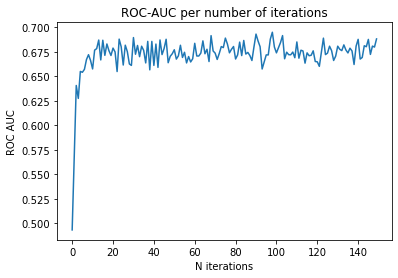

In [78]:
plt.plot(model_viola_jones_hog_pca.history.history['auc']);
plt.title('ROC-AUC per number of iterations');
plt.xlabel('N iterations');
plt.ylabel('ROC AUC');

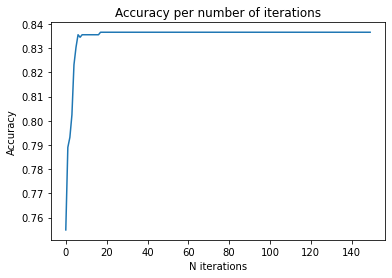

In [79]:
plt.plot(model_viola_jones_hog_pca.history.history['accuracy']);
plt.title('Accuracy per number of iterations');
plt.xlabel('N iterations');
plt.ylabel('Accuracy');

# Calculate metrics

In [80]:
train_datasets = (train_raw_hogs, train_raw_hogs_transformed, train_viola_jones_hogs,
                 train_viola_jones_hogs_transformed)

test_datasets = (test_raw_hogs, test_raw_hogs_transformed, test_viola_jones_hogs,
                test_viola_jones_hogs_transformed)

In [86]:
models_svc = (svc, svc_hog_transformed, svc_viola_jones_hog, svc_viola_jones_hog_transformed)
models_dense_net = (model_raw_hog, model_raw_hog_pca, model_viola_jones_hog,
                    model_viola_jones_hog_pca)

svc_models_titles = ('SVC_Raw_HOG_features', 'SVC_PCA_HOG_features',
                     'SVC_Viola_Jones_HOG_features','SVC_PCA_Viola_Jones_HOG_features')

dense_net_models_titles = ('DenseNet_Raw_HOG_features', 'DenseNet_PCA_HOG_features',
                           'DenseNet_Viola_Jones_HOG_features',
                           'DenseNet_PCA_Viola_Jones_HOG_features'
                          )

all_models_titles = ('SVC_Raw_HOG_features', 'SVC_PCA_HOG_features',
                     'SVC_Viola_Jones_HOG_features','SVC_PCA_Viola_Jones_HOG_features',
                    'DenseNet_Raw_HOG_features', 'DenseNet_PCA_HOG_features',
                     'DenseNet_Viola_Jones_HOG_features','DenseNet_PCA_Viola_Jones_HOG_features')

In [116]:
index_metrics = pd.MultiIndex.from_product((all_models_titles, ('train', 'test')))
columns_metrics = ['Accuracy', 'AUC', 'F1', 'Recall', 'Precision']

In [117]:
metrics_df = pd.DataFrame(index=index_metrics, columns=columns_metrics)

In [122]:
metrics_df.loc[('SVC_Raw_HOG_features', 'train'), 'Accuracy'] = accuracy_score(
    train_raw_hogs['target'], svc.predict(train_raw_hogs[hog_features]))

metrics_df.loc[('SVC_Raw_HOG_features', 'test'), 'Accuracy'] = accuracy_score(
    test_raw_hogs['target'], svc.predict(test_raw_hogs[hog_features]))

metrics_df.loc[('SVC_Raw_HOG_features', 'train'), 'AUC'] = roc_auc_score(
    train_raw_hogs['target'], svc.predict(train_raw_hogs[hog_features]))

metrics_df.loc[('SVC_Raw_HOG_features', 'test'), 'AUC'] = roc_auc_score(
    test_raw_hogs['target'], svc.predict(test_raw_hogs[hog_features]))

metrics_df.loc[('SVC_Raw_HOG_features', 'train'), 'F1'] = f1_score(
    train_raw_hogs['target'], svc.predict(train_raw_hogs[hog_features]))

metrics_df.loc[('SVC_Raw_HOG_features', 'test'), 'F1'] = f1_score(
    test_raw_hogs['target'], svc.predict(test_raw_hogs[hog_features]))

metrics_df.loc[('SVC_Raw_HOG_features', 'train'), 'Recall'] = recall_score(
    train_raw_hogs['target'], svc.predict(train_raw_hogs[hog_features]))

metrics_df.loc[('SVC_Raw_HOG_features', 'test'), 'Recall'] = recall_score(
    test_raw_hogs['target'], svc.predict(test_raw_hogs[hog_features]))

metrics_df.loc[('SVC_Raw_HOG_features', 'train'), 'Precision'] = precision_score(
    train_raw_hogs['target'], svc.predict(train_raw_hogs[hog_features]))

metrics_df.loc[('SVC_Raw_HOG_features', 'test'), 'Precision'] = precision_score(
    test_raw_hogs['target'], svc.predict(test_raw_hogs[hog_features]))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'train'), 'Accuracy'] = accuracy_score(
    train_viola_jones_hogs['target'],
    svc_viola_jones_hog.predict(train_viola_jones_hogs[viola_jones_hog_features]))

metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'test'), 'Accuracy'] = accuracy_score(
    test_viola_jones_hogs['target'], 
    svc_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]))

metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'train'), 'AUC'] = roc_auc_score(
    train_viola_jones_hogs['target'],
    svc_viola_jones_hog.predict(train_raw_hogs[viola_jones_hog_features]))

metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'test'), 'AUC'] = roc_auc_score(
    test_viola_jones_hogs['target'],
    svc_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]))

metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'train'), 'F1'] = f1_score(
    train_viola_jones_hogs['target'], 
    svc_viola_jones_hog.predict(train_viola_jones_hogs[viola_jones_hog_features]))

metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'test'), 'F1'] = f1_score(
    test_viola_jones_hogs['target'],
    svc_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]))

metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'train'), 'Recall'] = recall_score(
    train_viola_jones_hogs['target'],
    svc_viola_jones_hog.predict(train_viola_jones_hogs[viola_jones_hog_features]))

metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'test'), 'Recall'] = recall_score(
    test_viola_jones_hogs['target'],
    svc_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]))

metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'train'), 'Precision'] = precision_score(
    train_viola_jones_hogs['target'], 
    svc_viola_jones_hog.predict(train_viola_jones_hogs[viola_jones_hog_features]))

metrics_df.loc[('SVC_Viola_Jones_HOG_features', 'test'), 'Precision'] = precision_score(
    test_viola_jones_hogs['target'], 
    svc_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
metrics_df.loc[('SVC_PCA_HOG_features', 'train'), 'Accuracy'] = accuracy_score(
    train_raw_hogs['target'], svc_hog_transformed.predict(train_raw_hogs_transformed))

metrics_df.loc[('SVC_PCA_HOG_features', 'test'), 'Accuracy'] = accuracy_score(
    test_raw_hogs['target'], svc_hog_transformed.predict(test_raw_hogs_transformed))

metrics_df.loc[('SVC_PCA_HOG_features', 'train'), 'AUC'] = roc_auc_score(
    train_raw_hogs['target'], svc_hog_transformed.predict(train_raw_hogs_transformed))

metrics_df.loc[('SVC_PCA_HOG_features', 'test'), 'AUC'] = roc_auc_score(
    test_raw_hogs['target'], svc_hog_transformed.predict(test_raw_hogs_transformed))

metrics_df.loc[('SVC_PCA_HOG_features', 'train'), 'F1'] = f1_score(
    train_raw_hogs['target'], svc_hog_transformed.predict(train_raw_hogs_transformed))

metrics_df.loc[('SVC_PCA_HOG_features', 'test'), 'F1'] = f1_score(
    test_raw_hogs['target'], svc_hog_transformed.predict(test_raw_hogs_transformed))

metrics_df.loc[('SVC_PCA_HOG_features', 'train'), 'Recall'] = recall_score(
    train_raw_hogs['target'], svc_hog_transformed.predict(train_raw_hogs_transformed))

metrics_df.loc[('SVC_PCA_HOG_features', 'test'), 'Recall'] = recall_score(
    test_raw_hogs['target'], svc_hog_transformed.predict(test_raw_hogs_transformed))

metrics_df.loc[('SVC_PCA_HOG_features', 'train'), 'Precision'] = precision_score(
    train_raw_hogs['target'], svc_hog_transformed.predict(train_raw_hogs_transformed))

metrics_df.loc[('SVC_PCA_HOG_features', 'test'), 'Precision'] = precision_score(
    test_raw_hogs['target'], svc_hog_transformed.predict(test_raw_hogs_transformed))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [126]:
metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'train'), 'Accuracy'] = accuracy_score(
    train_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(train_viola_jones_hogs_transformed))

metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'test'), 'Accuracy'] = accuracy_score(
    test_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(test_viola_jones_hogs_transformed))

metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'train'), 'AUC'] = roc_auc_score(
    train_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(train_viola_jones_hogs_transformed))

metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'test'), 'AUC'] = roc_auc_score(
    test_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(test_viola_jones_hogs_transformed))

metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'train'), 'F1'] = f1_score(
    train_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(train_viola_jones_hogs_transformed))

metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'test'), 'F1'] = f1_score(
    test_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(test_viola_jones_hogs_transformed))

metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'train'), 'Recall'] = recall_score(
    train_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(train_viola_jones_hogs_transformed))

metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'test'), 'Recall'] = recall_score(
    test_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(test_viola_jones_hogs_transformed))

metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'train'), 'Precision'] = precision_score(
    train_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(train_viola_jones_hogs_transformed))

metrics_df.loc[('SVC_PCA_Viola_Jones_HOG_features', 'test'), 'Precision'] = precision_score(
    test_viola_jones_hogs['target'], svc_viola_jones_hog_transformed.predict(test_viola_jones_hogs_transformed))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Dense Net

In [129]:
metrics_df.loc[('DenseNet_Raw_HOG_features', 'train'), 'Accuracy'] = accuracy_score(
    train_raw_hogs['target'], model_raw_hog.predict(train_raw_hogs[hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Raw_HOG_features', 'test'), 'Accuracy'] = accuracy_score(
    test_raw_hogs['target'], model_raw_hog.predict(test_raw_hogs[hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Raw_HOG_features', 'train'), 'AUC'] = roc_auc_score(
    train_raw_hogs['target'], model_raw_hog.predict(train_raw_hogs[hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Raw_HOG_features', 'test'), 'AUC'] = roc_auc_score(
    test_raw_hogs['target'], model_raw_hog.predict(test_raw_hogs[hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Raw_HOG_features', 'train'), 'F1'] = f1_score(
    train_raw_hogs['target'], model_raw_hog.predict(train_raw_hogs[hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Raw_HOG_features', 'test'), 'F1'] = f1_score(
    test_raw_hogs['target'], model_raw_hog.predict(test_raw_hogs[hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Raw_HOG_features', 'train'), 'Recall'] = recall_score(
    train_raw_hogs['target'], model_raw_hog.predict(train_raw_hogs[hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Raw_HOG_features', 'test'), 'Recall'] = recall_score(
    test_raw_hogs['target'], model_raw_hog.predict(test_raw_hogs[hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Raw_HOG_features', 'train'), 'Precision'] = precision_score(
    train_raw_hogs['target'], model_raw_hog.predict(train_raw_hogs[hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Raw_HOG_features', 'test'), 'Precision'] = precision_score(
    test_raw_hogs['target'], model_raw_hog.predict(test_raw_hogs[hog_features]).flatten() > 0.5)

In [131]:
metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'train'), 'Accuracy'] = accuracy_score(
    train_viola_jones_hogs['target'],
    model_viola_jones_hog.predict(train_viola_jones_hogs[viola_jones_hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'test'), 'Accuracy'] = accuracy_score(
    test_viola_jones_hogs['target'], 
    model_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'train'), 'AUC'] = roc_auc_score(
    train_viola_jones_hogs['target'],
    model_viola_jones_hog.predict(train_raw_hogs[viola_jones_hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'test'), 'AUC'] = roc_auc_score(
    test_viola_jones_hogs['target'],
    model_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'train'), 'F1'] = f1_score(
    train_viola_jones_hogs['target'], 
    model_viola_jones_hog.predict(train_viola_jones_hogs[viola_jones_hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'test'), 'F1'] = f1_score(
    test_viola_jones_hogs['target'],
    model_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'train'), 'Recall'] = recall_score(
    train_viola_jones_hogs['target'],
    model_viola_jones_hog.predict(train_viola_jones_hogs[viola_jones_hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'test'), 'Recall'] = recall_score(
    test_viola_jones_hogs['target'],
    model_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'train'), 'Precision'] = precision_score(
    train_viola_jones_hogs['target'], 
    model_viola_jones_hog.predict(train_viola_jones_hogs[viola_jones_hog_features]).flatten() > 0.5)

metrics_df.loc[('DenseNet_Viola_Jones_HOG_features', 'test'), 'Precision'] = precision_score(
    test_viola_jones_hogs['target'], 
    model_viola_jones_hog.predict(test_viola_jones_hogs[viola_jones_hog_features]).flatten() > 0.5)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
metrics_df.loc[('DenseNet_PCA_HOG_features', 'train'), 'Accuracy'] = accuracy_score(
    train_raw_hogs['target'], model_raw_hog_pca.predict(train_raw_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_HOG_features', 'test'), 'Accuracy'] = accuracy_score(
    test_raw_hogs['target'], model_raw_hog_pca.predict(test_raw_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_HOG_features', 'train'), 'AUC'] = roc_auc_score(
    train_raw_hogs['target'], model_raw_hog_pca.predict(train_raw_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_HOG_features', 'test'), 'AUC'] = roc_auc_score(
    test_raw_hogs['target'], model_raw_hog_pca.predict(test_raw_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_HOG_features', 'train'), 'F1'] = f1_score(
    train_raw_hogs['target'], model_raw_hog_pca.predict(train_raw_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_HOG_features', 'test'), 'F1'] = f1_score(
    test_raw_hogs['target'], model_raw_hog_pca.predict(test_raw_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_HOG_features', 'train'), 'Recall'] = recall_score(
    train_raw_hogs['target'], model_raw_hog_pca.predict(train_raw_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_HOG_features', 'test'), 'Recall'] = recall_score(
    test_raw_hogs['target'], model_raw_hog_pca.predict(test_raw_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_HOG_features', 'train'), 'Precision'] = precision_score(
    train_raw_hogs['target'], model_raw_hog_pca.predict(train_raw_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_HOG_features', 'test'), 'Precision'] = precision_score(
    test_raw_hogs['target'], model_raw_hog_pca.predict(test_raw_hogs_transformed).flatten() > 0.5)

In [134]:
metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'train'), 'Accuracy'] = accuracy_score(
    train_viola_jones_hogs['target'], 
    model_viola_jones_hog_pca.predict(train_viola_jones_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'test'), 'Accuracy'] = accuracy_score(
    test_viola_jones_hogs['target'], 
    model_viola_jones_hog_pca.predict(test_viola_jones_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'train'), 'AUC'] = roc_auc_score(
    train_viola_jones_hogs['target'], 
    model_viola_jones_hog_pca.predict(train_viola_jones_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'test'), 'AUC'] = roc_auc_score(
    test_viola_jones_hogs['target'], 
    model_viola_jones_hog_pca.predict(test_viola_jones_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'train'), 'F1'] = f1_score(
    train_viola_jones_hogs['target'],
    model_viola_jones_hog_pca.predict(train_viola_jones_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'test'), 'F1'] = f1_score(
    test_viola_jones_hogs['target'],
    model_viola_jones_hog_pca.predict(test_viola_jones_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'train'), 'Recall'] = recall_score(
    train_viola_jones_hogs['target'], 
    model_viola_jones_hog_pca.predict(train_viola_jones_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'test'), 'Recall'] = recall_score(
    test_viola_jones_hogs['target'],
    model_viola_jones_hog_pca.predict(test_viola_jones_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'train'), 'Precision'] = precision_score(
    train_viola_jones_hogs['target'],
    model_viola_jones_hog_pca.predict(train_viola_jones_hogs_transformed).flatten() > 0.5)

metrics_df.loc[('DenseNet_PCA_Viola_Jones_HOG_features', 'test'), 'Precision'] = precision_score(
    test_viola_jones_hogs['target'],
    model_viola_jones_hog_pca.predict(test_viola_jones_hogs_transformed).flatten() > 0.5)

In [135]:
metrics_df

Accuracy       AUC        F1  \
SVC_Raw_HOG_features                  train  0.959669  0.907583  0.898172   
                                      test   0.783133       0.5         0   
SVC_PCA_HOG_features                  train  0.925543  0.829384  0.794286   
                                      test   0.783133       0.5         0   
SVC_Viola_Jones_HOG_features          train  0.830403       0.5  0.364341   
                                      test   0.783133       0.5         0   
SVC_PCA_Viola_Jones_HOG_features      train  0.830403  0.611374  0.364341   
                                      test   0.783133       0.5         0   
DenseNet_Raw_HOG_features             train         1         1         1   
                                      test    0.79759  0.557436  0.222222   
DenseNet_PCA_HOG_features             train         1         1         1   
                                      test   0.814458  0.596325  0.330435   
DenseNet_Viola_Jones_HOG_features     train  0.781799       0.5         0   
                                      test   0.783133       0.5         0   
DenseNet_PCA_Viola_Jones_HOG_features train  0.836608  0.625592  0.401515   
                                      test   0.785542  0.505556  0.021978   

                                                Recall Precision  
SVC_Raw_HOG_features                  train   0.815166         1  
                                      test           0         0  
SVC_PCA_HOG_features                  train   0.658768         1  
                                      test           0         0  
SVC_Viola_Jones_HOG_features          train   0.222749         1  
                                      test           0         0  
SVC_PCA_Viola_Jones_HOG_features      train   0.222749         1  
                                      test           0         0  
DenseNet_Raw_HOG_features             train          1         1  
                                      test    0.133333  0.666667  
DenseNet_PCA_HOG_features             train          1         1  
                                      test    0.211111      0.76  
DenseNet_Viola_Jones_HOG_features     train          0         0  
                                      test           0         0  
DenseNet_PCA_Viola_Jones_HOG_features train   0.251185         1  
                                      test   0.0111111         1

In [ ]:
metrics_df.to_csv('all_metrics_lab3.csv', index=True)